上篇文章，我介绍了如何建模累计成交量，以及简单对价格冲击现象进行了分析。本篇文章还将围绕着trades订单数据继续分析。这两天YGG上线币安U本位合约，价格波动很大，甚至成交量一度超过了BTC，今天就那它进行分析。

### 订单时间间隔

一般情况下都假设订单到达的时间符合泊松过程，这里有一篇文章介绍了[泊松过程](https://www.ruanyifeng.com/blog/2015/06/poisson-distribution.html) 。下面我将实证下。

下载8月5号的aggTrades，共有1931193条trades，非常夸张。首先还是先看下买单的分布，可以看到在100ms和500ms左右有个不平滑的局部峰值，应该是由冰山委托的机器人定时下单引起的，这可能也是当天行情不同寻常的原因之一。


泊松分布的概率质量函数（PMF）由以下公式给出：

$$P(k; \lambda) = \frac{\lambda^k e^{-\lambda}}{k!}$$

其中：

- $k$ 是我们感兴趣的事件数量。
- $\lambda$ 是单位时间（或单位空间）内事件的平均发生率。
- $P(k; \lambda)$ 表示在给定平均发生率 $\lambda$ 的条件下，恰好发生 $k$ 个事件的概率。

在泊松过程中，事件之间的时间间隔服从指数分布。指数分布的概率密度函数（PDF）由以下公式给出：

$$f(x; \lambda) = \lambda e^{-\lambda x}$$

通过拟合发现，结果和泊松分布的预期差别较大，泊松过程低估了长间隔时间的频率，高估了低间隔时间的频率。(实际间隔的分布更接近修正后的帕累托分布）


In [1]:
from datetime import date,datetime
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
trades = pd.read_csv('YGGUSDT-aggTrades-2023-08-05.csv')
trades['date'] = pd.to_datetime(trades['transact_time'], unit='ms')
trades.index = trades['date']
buy_trades = trades[trades['is_buyer_maker']==False].copy()
buy_trades = buy_trades.groupby('transact_time').agg({
    'agg_trade_id': 'last',
    'price': 'last',
    'quantity': 'sum',
    'first_trade_id': 'first',
    'last_trade_id': 'last',
    'is_buyer_maker': 'last',
    'date': 'last',
    'transact_time':'last'
})
buy_trades['interval']=buy_trades['transact_time'] - buy_trades['transact_time'].shift()
buy_trades.index = buy_trades['date']

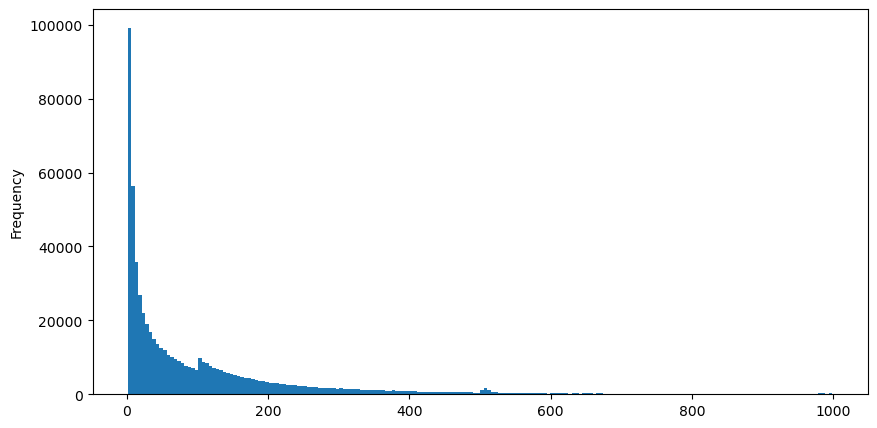

In [10]:
buy_trades['interval'][buy_trades['interval']<1000].plot.hist(bins=200,figsize=(10, 5));

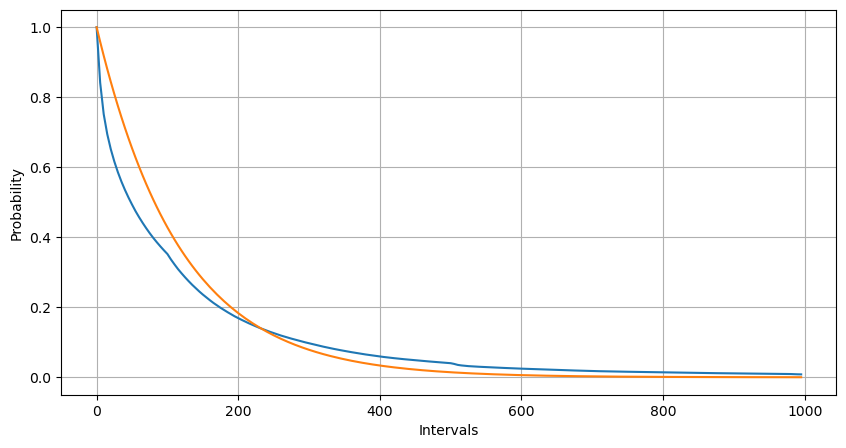

In [20]:
Intervals = np.array(range(0, 1000, 5))
mean_intervals = buy_trades['interval'].mean()
buy_rates = 1000/mean_intervals
probabilities = np.array([np.mean(buy_trades['interval'] > interval)  for interval in Intervals])
probabilities_s = np.array([np.e**(-buy_rates*interval/1000) for interval in Intervals])

plt.figure(figsize=(10, 5))
plt.plot(Intervals, probabilities)
plt.plot(Intervals, probabilities_s)
plt.xlabel('Intervals')
plt.ylabel('Probability')
plt.grid(True)

统计1s内订单发生次数的次数分布，和泊松分布进行比较，同样差别非常明显。泊松分布显著低估了小概率事件发生的频率 。可能的原因：

- 不恒定的发生率：泊松过程假设在任何给定的时间段内事件的平均发生率是常数。如果这个假设不成立，那么数据的分布会与泊松分布存在偏差。
- 过程的相互作用：泊松过程的另一个基本假设是事件之间是独立的。如果真实世界中的事件相互影响，那么它们的分布可能会偏离泊松分布。

也就是说，在真实的环境中 ，订单发生的频率是非恒定的，需要实时更新，并且会发生激励作用，即固定时间内更多的订单会激发更多的订单。这使得策略不能固定的单一参数。

In [190]:
result_df = buy_trades.resample('1S').agg({ 
    'price': 'count',
    'quantity': 'sum'
}).rename(columns={'price': 'order_count', 'quantity': 'quantity_sum'})

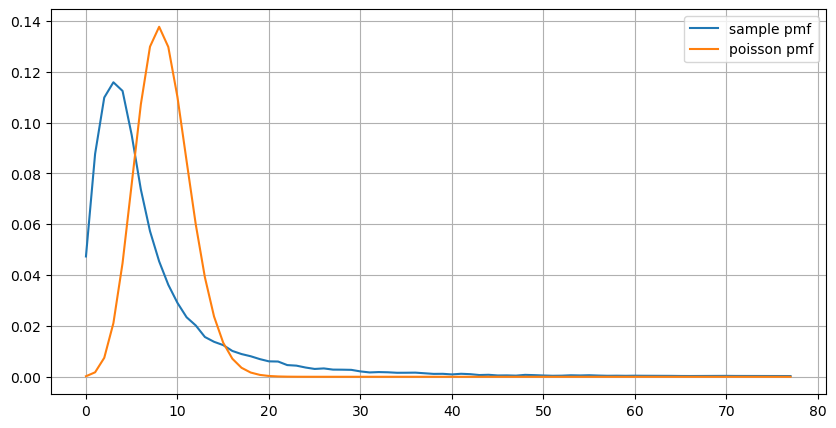

In [219]:
count_df = result_df['order_count'].value_counts().sort_index()[result_df['order_count'].value_counts()>20]
(count_df/count_df.sum()).plot(figsize=(10,5),grid=True,label='sample pmf');

from scipy.stats import poisson
prob_values = poisson.pmf(count_df.index, 1000/mean_intervals) 

plt.plot(count_df.index, prob_values,label='poisson pmf');
plt.legend() ;

### 实时更新参数

前面通过对订单间隔的分析可以得出结论，固定的参数不适合真实的市场行情，策略的对市场描述的关键参数需要实时更新。最容易想到的方案是滑动窗口的移动平均。下面两张图分别是1s内买单的频率和交易量的1000窗口的均值，可以看出来交易存在聚集现象，即有一段时间订单的频率显著高于平时,并且此时的量也同步增大。这里用上一个的均值来预测最新一秒的值，用残差的平均绝对误差的均值来衡量预测的好坏。

从图上也能理解为什么会订单频率会偏离泊松分布那么多，虽然每秒订单数量的均值只有8.5次，但极端情况每秒订单的均值远远偏离了。

这里发现用前两秒的均值来预测残差误差最小，并且远好于简单的均值预测结果。


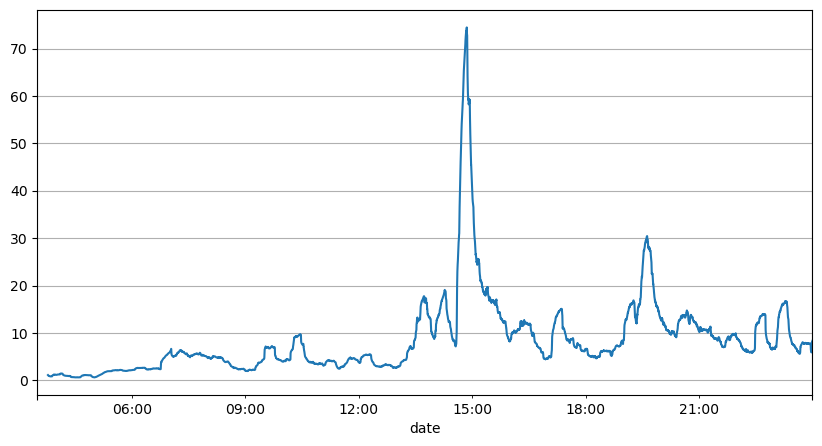

In [221]:
result_df['order_count'].rolling(1000).mean().plot(figsize=(10,5),grid=True);

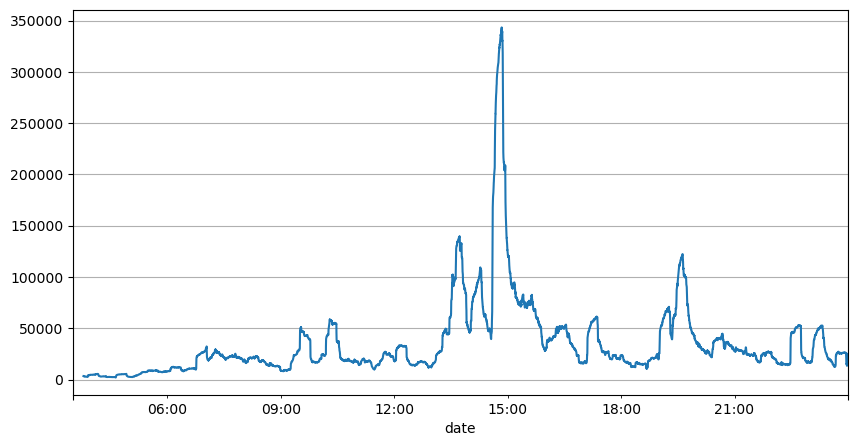

In [193]:
result_df['quantity_sum'].rolling(1000).mean().plot(figsize=(10,5),grid=True);

In [195]:
(result_df['order_count'] - result_df['mean_count'].mean()).abs().mean()

6.985628185332997

In [205]:
result_df['mean_count'] = result_df['order_count'].rolling(2).mean()
(result_df['order_count'] - result_df['mean_count'].shift()).abs().mean()

3.091737586730269

### 总结

本篇文章简单介绍了订单时间间隔偏离泊松过程的原因，主要是因为参数随时间变动。为了更准确的预测市场，策略需要对市场的基本参数做出实时的预测。用残差可以衡量预测的好坏，上面给出的是个最简单的示例，具体时间序列分析、波动率聚集等相关的研究非常多，可以进一步的改进。